In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import cv2
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Ayarlar
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4

# Dizinler
LABEL_CSV = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
DICOM_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"
PNG_DIR = "/kaggle/working/rsna_png"

os.makedirs(PNG_DIR, exist_ok=True)


In [9]:
df = pd.read_csv(LABEL_CSV)
df['filename'] = df['patientId'] + ".png"
print("Toplam hasta sayısı:", df['patientId'].nunique())

for pid in df['patientId'].unique():
    dcm_path = os.path.join(DICOM_DIR, pid + ".dcm")
    png_path = os.path.join(PNG_DIR, pid + ".png")

    if os.path.exists(png_path):
        continue

    dicom = pydicom.dcmread(dcm_path)
    img = dicom.pixel_array.astype(np.float32)

    if 'WindowCenter' in dicom and 'WindowWidth' in dicom:
        center = dicom.WindowCenter
        width = dicom.WindowWidth
        center = center[0] if isinstance(center, pydicom.multival.MultiValue) else center
        width = width[0] if isinstance(width, pydicom.multival.MultiValue) else width
        min_val = center - width / 2
        max_val = center + width / 2
        img = np.clip(img, min_val, max_val)
        img = ((img - min_val) / (max_val - min_val)) * 255.0
    else:
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255.0

    img = img.astype(np.uint8)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    cv2.imwrite(png_path, img)


Toplam hasta sayısı: 26684


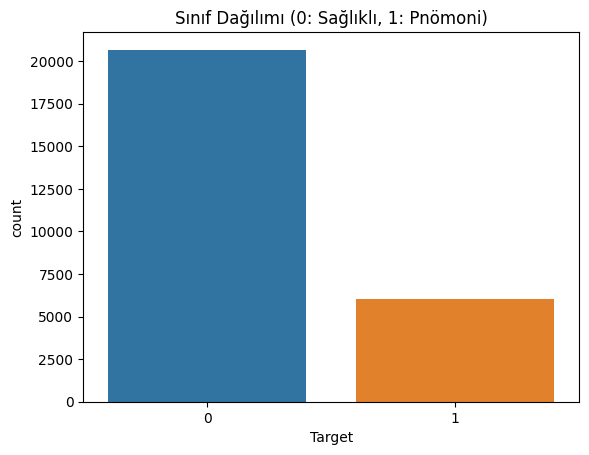

Pnömonili hasta sayısı: 6012
Sağlıklı hasta sayısı: 20672


In [10]:
df_unique = df[['patientId', 'Target']].drop_duplicates()
sns.countplot(data=df_unique, x='Target')
plt.title("Sınıf Dağılımı (0: Sağlıklı, 1: Pnömoni)")
plt.show()

print("Pnömonili hasta sayısı:", df_unique['Target'].value_counts()[1])
print("Sağlıklı hasta sayısı:", df_unique['Target'].value_counts()[0])


In [13]:
train_val_df, test_df = train_test_split(df_unique, test_size=0.2, stratify=df_unique['Target'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df['Target'], random_state=42)

train_df['filename'] = train_df['patientId'] + ".png"
val_df['filename'] = val_df['patientId'] + ".png"
test_df['filename'] = test_df['patientId'] + ".png"

weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_df['Target'].astype(int)), y=train_df['Target'].astype(int))
class_weights = dict(zip([0, 1], weights))
print("Sınıf Ağırlıkları:", class_weights)

train_df["Target"] = train_df["Target"].astype(str)
val_df["Target"] = val_df["Target"].astype(str)
test_df["Target"] = test_df["Target"].astype(str)


Sınıf Ağırlıkları: {0: 0.6454343882281798, 1: 2.218988218988219}


In [14]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=10, zoom_range=0.1, width_shift_range=0.05,
                                   height_shift_range=0.05, horizontal_flip=True)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(train_df, PNG_DIR, x_col='filename', y_col='Target',
                                              target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary', batch_size=BATCH_SIZE)

val_gen = val_datagen.flow_from_dataframe(val_df, PNG_DIR, x_col='filename', y_col='Target',
                                          target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary', batch_size=BATCH_SIZE, shuffle=False)

test_gen = val_datagen.flow_from_dataframe(test_df, PNG_DIR, x_col='filename', y_col='Target',
                                           target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary', batch_size=BATCH_SIZE, shuffle=False)


Found 19212 validated image filenames belonging to 2 classes.
Found 2135 validated image filenames belonging to 2 classes.
Found 5337 validated image filenames belonging to 2 classes.


In [15]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,6

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
callbacks = [
    EarlyStopping(patience=4, restore_best_weights=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(factor=0.5, patience=2, monitor='val_loss', verbose=1),
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', verbose=1)
]


In [17]:
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS,
                    class_weight=class_weights, callbacks=callbacks)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1750969401.232466      91 service.cc:148] XLA service 0x78ad4400eb30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750969401.233281      91 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750969401.690556      91 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/601 ━━━━━━━━━━━━━━━━━━━━ 45s 75ms/step - accuracy: 0.4531 - auc: 0.4777 - loss: 1.6443   

I0000 00:00:1750969410.131657      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.6399 - auc: 0.6848 - loss: 0.9407
Epoch 1: val_loss improved from inf to 0.55065, saving model to best_model.h5
601/601 ━━━━━━━━━━━━━━━━━━━━ 220s 347ms/step - accuracy: 0.6399 - auc: 0.6849 - loss: 0.9404 - val_accuracy: 0.7311 - val_auc: 0.8418 - val_loss: 0.5507 - learning_rate: 1.0000e-04
Epoch 2/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7130 - auc: 0.7841 - loss: 0.5792
Epoch 2: val_loss improved from 0.55065 to 0.50220, saving model to best_model.h5
601/601 ━━━━━━━━━━━━━━━━━━━━ 202s 337ms/step - accuracy: 0.7130 - auc: 0.7841 - loss: 0.5791 - val_accuracy: 0.7639 - val_auc: 0.8464 - val_loss: 0.5022 - learning_rate: 1.0000e-04
Epoch 3/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.7373 - auc: 0.8160 - loss: 0.5267
Epoch 3: val_loss did not improve from 0.50220
601/601 ━━━━━━━━━━━━━━━━━━━━ 197s 328ms/step - accuracy: 0.7373 - auc: 0.8160 - loss: 0.5267 - val_accuracy: 0.7358 - val_auc: 0.8464 - 

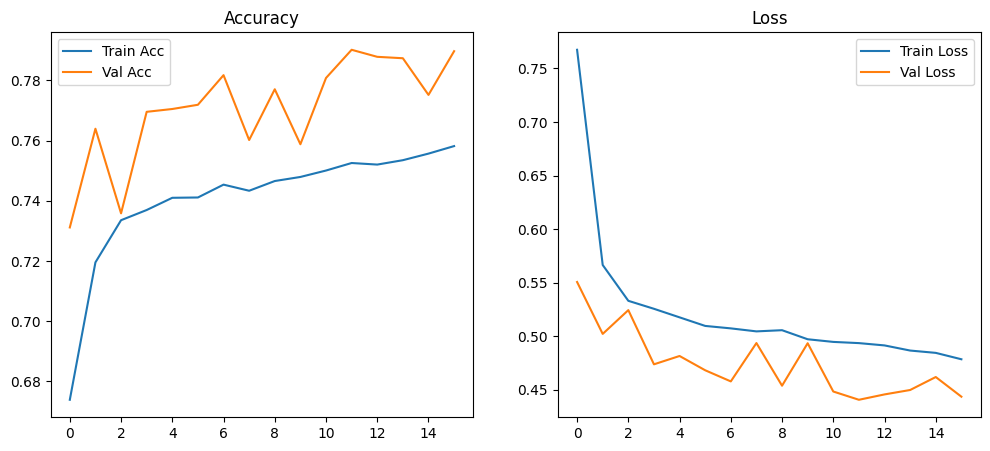

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()


In [19]:
y_probs = model.predict(test_gen).ravel()
y_pred = (y_probs > 0.5).astype(int)
y_true = test_gen.classes

print(classification_report(y_true, y_pred))
print("ROC AUC:", roc_auc_score(y_true, y_probs))


167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      4135
           1       0.50      0.71      0.59      1202

    accuracy                           0.78      5337
   macro avg       0.70      0.75      0.72      5337
weighted avg       0.81      0.78      0.79      5337

ROC AUC: 0.8416214813279762


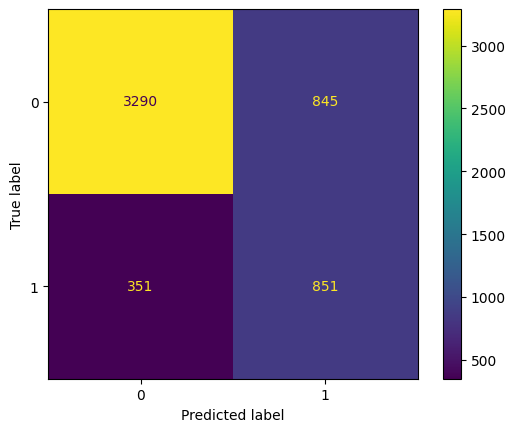

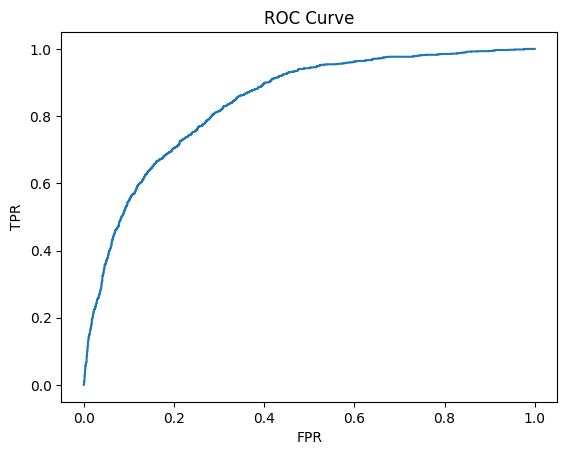

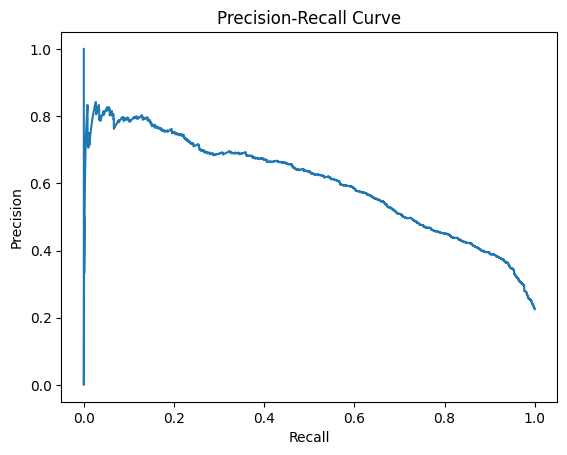

In [20]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.plot(fpr, tpr); plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

prec, rec, _ = precision_recall_curve(y_true, y_probs)
plt.plot(rec, prec); plt.title("Precision-Recall Curve"); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.show()
